# Solving A transverse field Ising model

In [105]:
using Yao
using Statistics: mean
using LinearAlgebra
using Plots

## Model Hamiltonians

### Transverse field Ising Model

$H = \sum\limits_{i=1}^{N-1} s_i^z s^z_{i+1} + h\sum\limits^{N}_{i=1} s_i^x$

where $s^\alpha = \frac 1 2 \sigma^\alpha$ is the spin operator.

In [106]:
"""
for simplicity, we require an AbstractModel contains `size` and `periodic` members.
"""
abstract type AbstractModel{D} end

nspin(model::AbstractModel) = prod(model.size)

nspin (generic function with 1 method)

In [ ]:
"""
transverse field ising model, `h` is the strength of transverse field.
"""
struct TFI{D} <:AbstractModel{1}
    size::NTuple{D, Int}
    h::Float64
    periodic::Bool
    TFI(size::Int...; h::Real, periodic::Bool) = new{length(size)}(size, Float64(h), periodic)
end

In [ ]:
"""
get the bonds of a chain model.
"""
function get_bonds(model::AbstractModel{1})
    nbit, = model.size
    [(i, i%nbit+1) for i in 1:(model.periodic ? nbit : nbit-1)]
end

In [ ]:
"""
Get the hamiltonian of a TFI model
"""
function hamiltonian(model::TFI)
    nbit = nspin(model)
    sum(repeat(nbit, Z, (i,j)) for (i,j) in get_bonds(model))*0.25 +
    sum(put(nbit, i=>X) for i=1:nbit)*0.5model.h
end

In [ ]:
tfi_model = TFI(4; h=0.5, periodic=false)

In [ ]:
tfi_h = hamiltonian(tfi_model)

# A quantum circuit as an ansatz

Construct the following circuit as our ansatz

<div style="display:inline-block"><img style="float:left", src="images/fourqubit.png" width="500"></div>

In [ ]:
dump(Measure)

In [ ]:
Rxz() = chain(Rx(0.0), Rz(0.0))
MeasureOp(nbit::Int, i::Int) = Measure{nbit, 1, AbstractBlock}(Z, (i,), nothing, false)

function ansatz_circuit(nbit::Int, d::Int)
    circuit = chain(nbit)

    for i=1:nbit-1
        unit = chain(nbit)
        for j=1:d
            push!(unit, put(nbit, i=>Rxz()))
            push!(unit, put(nbit, nbit=>Rxz()))
            push!(unit, control(nbit, 1, 2=>shift(0.0)))
        end
        push!(circuit, unit)
    end
    push!(circuit, chain([MeasureOp(nbit, i) for i=1:nbit]))
    circuit
end

In [ ]:
example_circuit = ansatz_circuit(4, 1)

In [ ]:
nparameters(example_circuit)

In [ ]:
"""
    gensample(circuit, operator; nbatch=1024) -> Vector of Measure

Generate samples from MPS-inspired circuit. Here, `nbatch` means nshot.
`operator` is the operator to measure.
This function returns a vector of `Measure` gates, results are stored in `m.results`.
"""
function gensample(circuit, operator; nbatch=1024)
    mblocks = collect_blocks(Measure, circuit)
    for m in mblocks
        m.operator = operator
    end
    reg = zero_state(nqubits(circuit); nbatch=nbatch)
    reg |> circuit
    mblocks
end

In [ ]:
res = gensample(example_circuit, X; nbatch=1024)

In [ ]:
res[1].results

Get the energy through sampling

In [ ]:
"""
    VQE{MT, BT<:AbstractBlock}

Variational quantum eigensolver setup
* `MT` is the type of hamiltonian model,
* `BT` is the type of an input circuit.
"""
struct VQE{MT, BT<:AbstractBlock}
    model::MT
    circuit::BT
    nshots::Int
end

VQE(model, circuit::AbstractBlock; nshots::Int=1024) = VQE(model, circuit, nshots)

## Loss Function

In [ ]:
"""
Obtain the energy of a VQE application.
"""
function energy(vqe::VQE{<:TFI})
    # measuring Z
    eng = ising_energy(vqe.circuit, get_bonds(vqe.model), Z; nshots=vqe.nshots)
    # measuring transverse field term on basis X
    mblocks = gensample(vqe.circuit, X; nbatch=vqe.nshots)
    engx = sum(mean.([m.results for m in mblocks]))
    eng + vqe.model.h*engx/2
end

function ising_energy(circuit, bonds, basis; nshots::Int)
    mblocks = gensample(circuit, basis; nbatch=nshots)
    nspin = length(mblocks)
    local eng = 0.0
    for (a, b) in bonds
        eng += mean(mblocks[a].results .* mblocks[b].results)
    end
    eng/=4
end

In [ ]:
# obtain the energy through sampling
vqe = VQE(tfi_model, example_circuit; nshots=1024)
dispatch!(vqe.circuit, :random)
energy(vqe)

## Training

Sequential optimization
1. obtain the gradient of one parameter a time $\frac{\partial E_\theta}{\partial \theta} = \frac 1 2 (E_{\theta+\pi/2}-E_{\theta-\pi/2})$
2. perform gradient descent update of this parameter $\theta\rightarrow \theta-\alpha \frac{\partial E_\theta}{\partial \theta}$
3. sweep all parameters until convergence.

In [ ]:
"""
obtain the gradient of a parameter in a rotation gate/cphase gate.
"""
function opgrad(vqe::VQE, r)
    dispatch!(+, r, π/2)
    E₊ = energy(vqe)
    dispatch!(-, r, π)
    E₋ = energy(vqe)
    dispatch!(+, r, π/2)
    0.5*(E₊ - E₋)
end

In [ ]:
using Flux: ADAM, Optimise

In [164]:
function train!(vqe::VQE; maxiter::Int=200, α::Real=0.3)
    circuit, model = vqe.circuit, vqe.model
    rots = collect_blocks(Union{RotationGate, ControlBlock{<:Any, <:ShiftGate}}, circuit)
    loss_history = Float64[]
    params = vcat(parameters.(rots)...)
    optimizer = ADAM(α)
    for i in 0:maxiter
        grad = opgrad.(Ref(vqe), rots)
        Optimise.update!(optimizer, params, grad)
        dispatch!.(rots, params)
        push!(loss_history, energy(vqe)/nspin(model))
        
        i%10 == 0 && println("Iter $i, E/N = $(loss_history[end])")
    end
    loss_history, circuit
end

train! (generic function with 1 method)

In [165]:
lattice_size = 4
vqe = VQE(TFI(lattice_size; h=0.5, periodic=false),
    ansatz_circuit(lattice_size, 2);
    nshots=1024);

In [166]:
# obtain the exact ground state energy
res = eigen(mat(hamiltonian(vqe.model)) |> Matrix)
EG = res.values[1]/nspin(vqe.model)
@show EG
VG = res.vectors[:,1];

EG = -0.29742315519647605


In [167]:
nparameters(vqe.circuit)

30

In [168]:
dispatch!(vqe.circuit, :random)
loss_history, circuit = train!(vqe; maxiter=100, α=0.3);

Iter 0, E/N = -0.0887451171875
Iter 10, E/N = -0.2269287109375
Iter 20, E/N = -0.2728271484375
Iter 30, E/N = -0.282470703125
Iter 40, E/N = -0.2672119140625
Iter 50, E/N = -0.2684326171875
Iter 60, E/N = -0.2769775390625
Iter 70, E/N = -0.277099609375
Iter 80, E/N = -0.272705078125
Iter 90, E/N = -0.278564453125
Iter 100, E/N = -0.2783203125


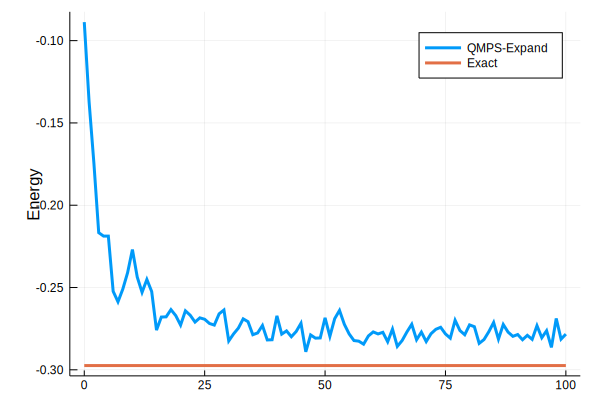

In [169]:
M = length(loss_history)
plot(0:M-1, [loss_history, fill(EG, M)], label=["QMPS-Expand", "Exact"], lw=3, ylabel="Energy")

## Task 1: The problem of vanishing gradient
Change the circuit size (as well as model lattice size), show the variance of gradient items.

#### Hint: useful functions
* using Statistics: var
* Use `energy_exact` instead of `energy` to avoid sampling error

In [170]:
wave_function(circuit) = zero_state(nqubits(circuit)) |> circuit[1:end-1]

wave_function (generic function with 1 method)

In [128]:
# obtain the exact <H> through wave function
energy_exact(vqe) = expect(hamiltonian(vqe.model), wave_function(vqe.circuit)) |> real

energy_exact (generic function with 1 method)

In [153]:
function opgrad_exact(vqe::VQE, r)
    dispatch!(+, r, π/2)
    E₊ = energy_exact(vqe)
    dispatch!(-, r, π)
    E₋ = energy_exact(vqe)
    dispatch!(+, r, π/2)
    0.5*(E₊ - E₋)
end

opgrad_exact (generic function with 1 method)

In [154]:
using Statistics

function rand_gradient(nbit::Int)
    d = 3
    circuit = ansatz_circuit(nbit, d)
    model = TFI(nbit; h=0.5, periodic=false)
    vqe = VQE(model, circuit, nshots=1)
    dispatch!(circuit, :random)
    r = rand(collect_blocks(RotationGate, circuit))
    opgrad_exact(vqe, r)
end

maxN = 9
grad_vars = [(println(N); mean([abs(rand_gradient(N)) for i=1:300])) for N=2:maxN]

2
3
4
5
6
7
8
9


8-element Array{Float64,1}:
 0.07549153741128896
 0.09583226381779932
 0.11916702798334385
 0.10823850341118278
 0.09526693782285131
 0.09561843871114195
 0.10251840223865968
 0.10697407003096228

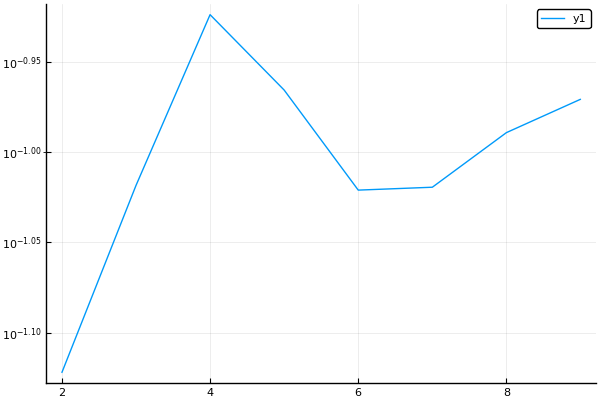

In [157]:
# there is no exponential gradient vanishing
# please compare it with the result in notebook `variational_qantum_circuit.ipynb`
pyplot()
ax = plot(2:maxN, grad_vars, yscale=:log10)

## Task 2: Two qubits simulating a four-qubit systems

Hadamard Gate with dashed box is applied only when measuring on the X basis.
<div style="display:inline-block"><img style="float: left", src="images/hgate.png" width="50"/></div>

The following gates Measure and Reset a qubit to 0.

<div style="display:inline-block"><img style="float:left", src="images/mreset.png" width="100"></div>

The goal of this section is to build the MPS-inspired sampler as our ansatz

<div style="display:inline-block"><img style="float:left", src="images/twoqubit.png"></div>

### Reference: Variational Quantum Eigensolver with Fewer Qubits

*Jin-Guo Liu, Yi-Hong Zhang, Yuan Wan, Lei Wang*

https://arxiv.org/abs/1902.02663

In [107]:
# Hint
MeasureAndReset(nbit::Int, i::Int) = Measure{nbit, 1, AbstractBlock}(Z, (i,), 0, false)

MeasureAndReset (generic function with 1 method)

In [119]:
"""
    ansatz_circuit_2qubit(nbit::Int, d::Int)

Construct the above ansatz, `nrepeat` is the number of measure operations,
`d` is the depth of each block between two measurements.
"""
function ansatz_circuit_2qubit(nbit::Int, d::Int)
    Nv = 1
    nbit_used = 1+Nv
    nrepeat = nbit - Nv
    circuit = chain(nbit_used)

    for i=1:nrepeat
        unit = chain(nbit_used)
        for j=1:d
            push!(unit, put(nbit_used, 1=>Rxz()))
            push!(unit, put(nbit_used, 2=>Rxz()))
            push!(unit, control(nbit_used, 1, 2=>shift(0.0)))
        end
        push!(unit, MeasureAndReset(nbit_used, 1))
        if i==nrepeat
            for k=2:nbit_used
                push!(unit, MeasureAndReset(nbit_used, k))
            end
        end
        push!(circuit, unit)
    end
    circuit
end

ansatz_circuit_2qubit

In [205]:
lattice_size = 4
vqe = VQE(TFI(lattice_size; h=0.5, periodic=false),
    ansatz_circuit_2qubit(lattice_size, 2);
    nshots=4000);

In [206]:
nparameters(vqe.circuit)

30

In [201]:
"""
    gensample(circuit, operator; nbatch=1024) -> Vector of Measure

Generate samples from MPS-inspired circuit. Here, `nbatch` means nshot.
`operator` is the operator to measure.
This function returns a vector of `Measure` gates, results are stored in `m.results`.
"""
function gensample(circuit, operator; nbatch=1024)
    mblocks = collect_blocks(Measure, circuit)
    for m in mblocks
        m.operator = operator
    end
    reg = zero_state(nqubits(circuit); nbatch=nbatch)
    reg |> circuit
    mblocks
end

gensample

In [202]:
dispatch!(vqe.circuit, :random)
@time loss_history, circuit = train!(vqe; maxiter=100, α=0.3);

Iter 0, E/N = 0.02584375
Iter 10, E/N = -0.24709375
Iter 20, E/N = -0.25425
Iter 30, E/N = -0.27565625
Iter 40, E/N = -0.27749999999999997
Iter 50, E/N = -0.2753125
Iter 60, E/N = -0.27965625
Iter 70, E/N = -0.27903124999999995
Iter 80, E/N = -0.27603125
Iter 90, E/N = -0.27775
Iter 100, E/N = -0.27890624999999997
100.322192 seconds (1.15 G allocations: 130.021 GiB, 34.81% gc time)


In [207]:
using CuYao

In [208]:
"""
    gensample(circuit, operator; nbatch=1024) -> Vector of Measure

Generate samples from MPS-inspired circuit. Here, `nbatch` means nshot.
`operator` is the operator to measure.
This function returns a vector of `Measure` gates, results are stored in `m.results`.
"""
function gensample(circuit, operator; nbatch=1024)
    mblocks = collect_blocks(Measure, circuit)
    for m in mblocks
        m.operator = operator
    end
    reg = zero_state(nqubits(circuit); nbatch=nbatch) |> cu
    reg |> circuit
    mblocks
end

gensample

In [209]:
dispatch!(vqe.circuit, :random)
@time loss_history, circuit = train!(vqe; maxiter=100, α=0.3);

Iter 0, E/N = -0.0021562499999999984
Iter 10, E/N = -0.24275000000000002
Iter 20, E/N = -0.2655625
Iter 30, E/N = -0.276625
Iter 40, E/N = -0.277625
Iter 50, E/N = -0.27696875
Iter 60, E/N = -0.27659374999999997
Iter 70, E/N = -0.28025
Iter 80, E/N = -0.27690625
Iter 90, E/N = -0.27653125
Iter 100, E/N = -0.27893749999999995
 81.006458 seconds (783.97 M allocations: 60.921 GiB, 22.79% gc time)


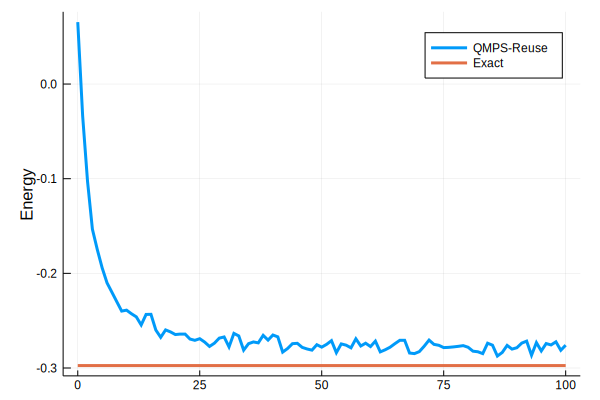

In [163]:
M = length(loss_history)
gr()
plot(0:M-1, [loss_history, fill(EG, M)], labels=["QMPS-Reuse", "Exact"], lw=3, ylabel="Energy")